# Solution Assignment 3: Convolutional Neural Network
This is the solution for the third assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip.

## Imports
We are going to use `tensorflow` to implement the neural network, `numpy` for the preparation of our training data and `matplotlib` to plot the training process. The `pickle` library is required to read the CIFAR-10 files and `os` is required to join directory paths. Finally, we activate inline plotting by calling `%matplotlib notebook`.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

%matplotlib notebook

## The CIFAR helper class
When an instance of this class is created, the training and test images and coresponding labels are read from the CIFAR-10 pickled files from `directory`. Further, 10% of the training data images are separated into a validation data-set.

The class provides three methods to iterate over the training, validation and test data respectively. If `batch_size` is set to a value `<= 0`, the method returns all data and labels at once.

In [2]:
class CIFAR():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
        
    
    def _load_traing_data(self):
        for i in range(1, 6):
            path = os.path.join(self._directory, "data_batch_" + str(i))
            with open(path, 'rb') as fd:
                cifar_data = pickle.load(fd, encoding = "bytes")
                imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
                imgs = imgs.transpose([0, 2, 3, 1])
                if i == 1:
                    self._training_data = imgs
                    self._training_labels = cifar_data[b"labels"]
                else:
                    self._training_data = np.concatenate([self._training_data, imgs], axis = 0)
                    self._training_labels = np.concatenate([self._training_labels, cifar_data[b"labels"]])
    
    def _load_test_data(self):
        path = os.path.join(self._directory, "test_batch")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"labels"])
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    

## Creating a new CIFAR instance
Since the CIFAR class reads the CIFAR data every time we create a new instance, we are going to create a single instance here and reuse it in the cells bellow.

This script assumes, that the CIFAR data files are located in a subdirectory "data".

In [3]:
cifar = CIFAR("./data/")

## Investigating the data
Before we start to use the data we should always try to understand its structure and double check, that data and labels are assigned correctly. Therefore, we plot some samples and the respective labels.

In [1]:
images, labels = next(cifar.get_training_batch(15))

label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(str(labels[i]) + ": " + label_to_word[labels[i]])

NameError: name 'cifar' is not defined

## Construction phase
In the construction phase we define the data flow graph with the help of TensorFlow's mathematical operations.

![PICTURE MISSING](cnn-network-structure.png)

For all our neurons, except for those of the output layer, we use the hyperbolic function as activation function. First of all, we define two placeholders: One for the mini-batch of images and another one for the respective labels.


In [5]:
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
desired = tf.placeholder(tf.int64, shape = [None])

print(x.shape)

(?, 32, 32, 3)


Next, we define the data flow graph for our convolutional neural network. We define our weights and our biases as variables, since those are the values that we want to keep and adjust in between training steps.

In the first layer, we apply 16 kernels of size 5x5x3 to the 32x32x3 input data. While 5x5 is the spatial dimension of the kernel (height x width) and x3 is the depth of the kernel and is applied to the three color channels of the image. This yields 16 individual feature maps of the same spatial dimension as the input data (32x32).

Then, in order to reduce the spatial dimensionality of the data, we apply max-pooling to the 16 feautre maps with a kernel size of 2x2 and a stride size of 2x2. This operation yields 16 feature maps of size 16x16.

In [6]:
kernels_1 = tf.Variable(tf.truncated_normal([5, 5, 3, 16], stddev = 0.1))
convolution_1 = tf.nn.conv2d(x, kernels_1, strides = [1, 1, 1, 1], padding = "SAME")

biases_1 = tf.Variable(tf.constant(0.0, shape = [16]))
feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1)
print(feature_maps_1.shape)

pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
print(pool_1.shape)

(?, 32, 32, 16)
(?, 16, 16, 16)


In the second convolutional layer, we want to combine the features that we have extracted in the first convolution step. Hence, the kernels that we apply are 16 layers deep. We apply 32 different kernels. Again, we apply max-pooling to the feature maps. The spatial dimensionality is reduced to 8x8.

In [7]:
kernels_2 = tf.Variable(tf.truncated_normal([3, 3, 16, 32], stddev = 0.1))
convolution_2 = tf.nn.conv2d(pool_1, kernels_2, strides = [1, 1, 1, 1], padding = "SAME")

biases_2 = tf.Variable(tf.constant(0.0, shape = [32]))
feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2)
print(feature_maps_2.shape)

pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
print(pool_2.shape)

(?, 16, 16, 32)
(?, 8, 8, 32)


These 32 feature maps of size 8x8 are than reshaped to a vector and fed into a fully conected two layer feed-forward neural network. The hidden layer has 512 neurons and the second layer, the output layer has 10 neurons. One neuron for each of the categories.

In [8]:
flattened = tf.reshape(pool_2, [-1, 8 * 8 * 32])
print(flattened.shape)

weights_3 = tf.Variable(tf.truncated_normal([2048, 512], stddev = 2048**(-1/2)))
biases_3 = tf.Variable(tf.constant(0.0, shape = [512]))
hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3)
print(hidden_layer.shape)

weights_4 = tf.Variable(tf.truncated_normal([512, 10], stddev = 512**(-1/2)))
biases_4 = tf.Variable(tf.constant(0.0, shape = [10]))
output_layer_logits = tf.matmul(hidden_layer, weights_4) + biases_4
print(output_layer_logits.shape)

(?, 2048)
(?, 512)
(?, 10)


The activation function of the output layer, in this case the softmax function, is going to be applied by the `sparse_softmax_cross_entropy_with_logits` function, which also calculates the cross entropy between the _logits_ and the desired output for us.

Since we are going to train with mini-batches, we will receive one cross entropy value for each sample in our mini-batch. In order to get a measure of the networks overall performance on the mini-batch, we calculate the mean of the different cross entropy values.

In [9]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = output_layer_logits)
cross_entropy = tf.reduce_mean(cross_entropy)

Next, we are going to specify the gradient descent algorithm that we would like to use in order to minimize the error of our network by adjusting the variables. In this case, we are going to use the Adam Optimzier with a learning rate of `1e-4`.

Further, we create a measure for the accuracy of our network by calculating the amount of correctly labeled samples.

In [10]:
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate)
training_step = optimizer.minimize(cross_entropy)

accuracy = tf.equal(tf.argmax(tf.nn.softmax(output_layer_logits), 1), desired)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

## Execution phase
In the execution phase we create a new session and evaluate parts of our data flow graph by feeding data into the placeholders and requesting node's values.

First of all, we define our meta parameters: The amount of training epochs, the mini-batch size and how often we validate the performance of our network and update the plots.

In [11]:
epochs = 3
mini_batch_size = 200
plot_step_size = 50
training_steps = cifar.get_sizes()[0] // mini_batch_size

Next, we create variables and figures that we will use to plot the current cross entropy and accuracies to monitor the training process of our network.

<IPython.core.display.Javascript object>


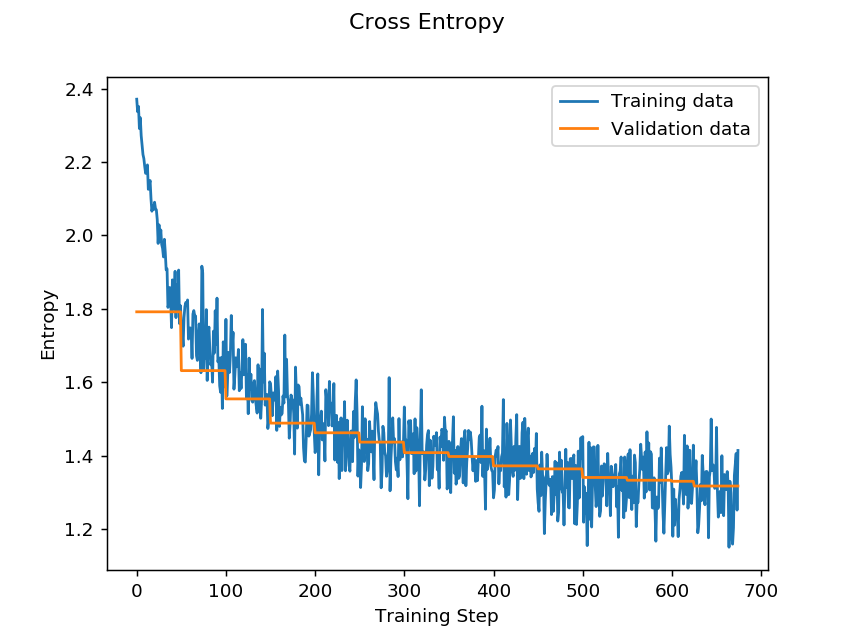

<IPython.core.display.Javascript object>


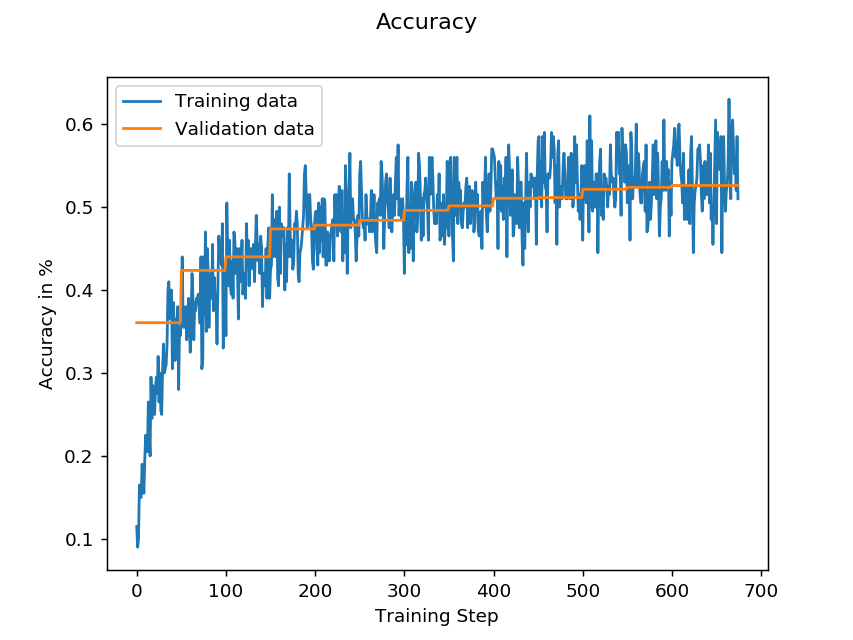

In [12]:
training_cross_entropies = np.zeros(training_steps * epochs)
validation_cross_entropies = np.zeros(training_steps * epochs)

training_accuracies = np.ones(training_steps * epochs)
validation_accuracies = np.ones(training_steps * epochs)

fig_cross_entropy, ax_cross_entropy = plt.subplots()
fig_cross_entropy.suptitle("Cross Entropy")

fig_accuracy, ax_accuracy = plt.subplots()
fig_accuracy.suptitle("Accuracy")

## Training
Finally, we train our network by first createing a session and then training the network with mini-batches. After training the network, we estimate the application phase accuracy with the help of the test data.

In [13]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    step = 0
    last_step = False
    for epoch in range(epochs):
        for images, labels in cifar.get_training_batch(mini_batch_size):
            training_cross_entropies[step], training_accuracies[step], _ = session.run(
                [cross_entropy, accuracy, training_step],
                feed_dict = {x: images, desired: labels}
            )
            
            if step == (training_steps * epochs)-1:
                last_step = True
            
            if step % plot_step_size == 0 or last_step:
                images, labels = next(cifar.get_validation_batch(0))
                
                validation_cross_entropy, validation_accuracy, activations = session.run(
                    [cross_entropy, accuracy, output_layer_logits],
                    feed_dict = {x: images, desired: labels}
                )
                
                if step != 0:
                    on = step - plot_step_size if not last_step else step - plot_step_size + 1
                    off = on + plot_step_size
                    validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                    validation_accuracies[on:off] = [validation_accuracy] * plot_step_size
                
                ax_cross_entropy.cla()
                ax_cross_entropy.plot(training_cross_entropies, label = "Training data")
                ax_cross_entropy.plot(validation_cross_entropies, label = "Validation data")
                ax_cross_entropy.set_xlabel("Training Step")
                ax_cross_entropy.set_ylabel("Entropy")
                ax_cross_entropy.legend()
                fig_cross_entropy.canvas.draw()
                
                ax_accuracy.cla()
                ax_accuracy.plot(training_accuracies, label = "Training data")
                ax_accuracy.plot(validation_accuracies, label = "Validation data")
                ax_accuracy.set_xlabel("Training Step")
                ax_accuracy.set_ylabel("Accuracy in %")
                ax_accuracy.legend()
                fig_accuracy.canvas.draw()
                
            step += 1
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(cifar.get_test_batch(mini_batch_size)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, desired: labels}
        )
        
    print("Test Accuracy: " + str(test_accuracy / step))

Test Accuracy: 0.542346905689


## Amount of neurons, degrees of freedom and floating-point operations
Each value in a feature map represents the output of a neuron. To calculate the amount of simulated neurons we can hence add up the pixels in our feature maps and add the neurons of the feed-forward layers:

1. First Convolutional Layer: 32x32x16 = 16384 neurons
2. Second Convolutional Layer: 16x16x32 = 8192 neurons
3. First Feed Forward Layer: 512 neurons
4. Output Layer: 10 Neurons

__Total: 25.098 neurons__

Next, lets calculate the degrees of freedom. This is equivalent to the amount of weights and biases:

1. First Convolutional Layer:   
    Kernels: 3x3x3x16 = 432   
    Biases: 16
2. Second Convolutional Layer:
    Kernels: 3x3x16x32 = 4.608   
    Biases: 32
3. First Feed Forward Layer:   
    Kernels: 8x8x32x512 = 1.048.576   
    Biases: 512
4. Output Layer:   
    Kernels: 1024x10 = 10.240   
    Biases: 10

__Total: 1.064.426 __


Finally, the amount of floating-point operations for a single forward step:


1. First Convolutional Layer:   
    32x32x(5x5x3+((5x5x3)-1)) + 16 = 152.592
2. Second Convolutional Layer:
    16x16x(3x3x16+((3x3x16)-1)) + 32 = 73.504
3. First Feed Forward Layer:   
    32x8x8x(512 + 511) + 512 = 2.095.616
4. Output Layer:   
    512x(10 + 9) + 10 = 9.737
    
__Total: 2.331.449 __